# Brain MRI Tumor Classification

In this notebook, I wrote a binary classification model using no more than numpy (python library for mathematical operations). This is my first model in the field of computer vision. It inputs an image of an MRI Scan of a brain, and outputs a binary label on whether it detects a tumor or not.

I defined in `cnn.py`, a Convolution class which processes the input image, and a Max Pooling layer that decreases the output size of the convolution before passing that into a fully connected Neural Network of ReLU layers that uses a sigmoid function to output the final binary label.  

## `cnn.py`

<div style="width: 100%; max-height: 400px; overflow-y: scroll; border: 1px solid #ccc;">
  <img src="images/carbon.png" alt="Long Image">
</div>

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import cnn
import helper

## Data Extraction
The dataset i'll be using is a very interesting one called **"Brain MRI Images for Brain Tumor Detection"**  
It's contents are very simple, containined images of brain MRI without tumors, and with tumors.  

Here's a preview:  
<img src="images/tumor.png" style="max-height: 250px;">

Citation:
> 📊 **Dataset Reference**  
> https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

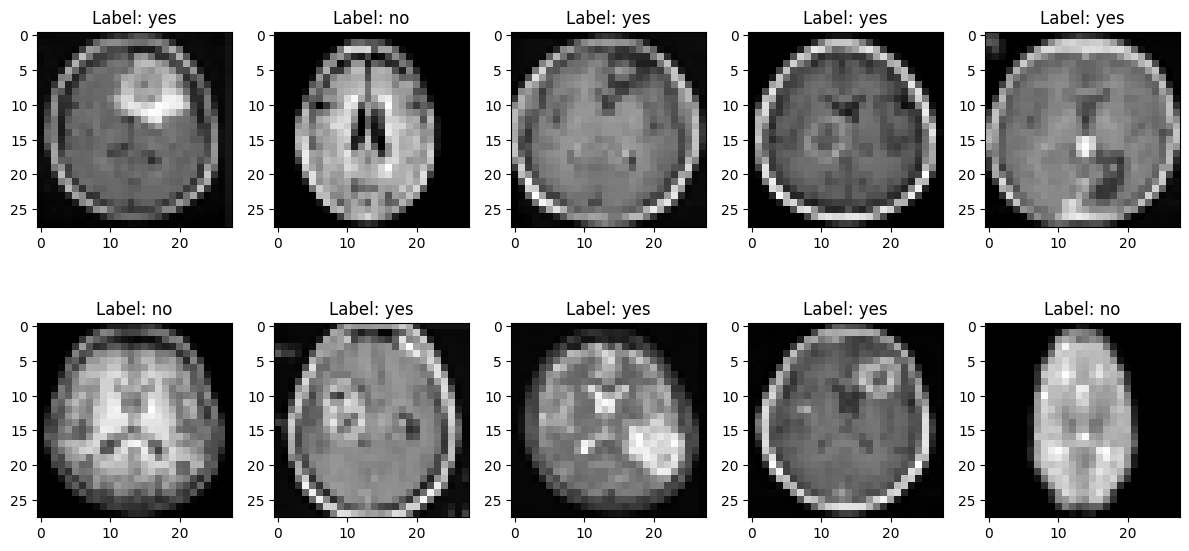

In [81]:
x_raw, y_raw = helper.load_dataset('brain_tumor_dataset') # unshuffled x and y
indices = np.random.permutation(len(x_raw)) # random indices
x, y = x_raw[indices], y_raw[indices]

class_names = ['no', 'yes']
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x[i], cmap='gray')
    plt.title(f'Label: {class_names[y[i]]}')
plt.tight_layout()
plt.show()

## Initializing Parameters

In a deep neural network, the dimensions of parameters for each layer is: (dimension of current layer, dimension of previous layer).
I'll create a function that takes input the dimensions of the neural network, and outputs a list of parameters.

In [82]:
def initialize_parameters_deep(architecture):
    np.random.seed(42)
    parameters = {}
    for l in range(1, len(architecture)):
        input_dim = architecture[l-1]['input_dim'] if 'input_dim' in architecture[l-1] else architecture[l-1]['units']
        parameters['W' + str(l)] = np.random.randn(architecture[l]['units'], input_dim) * np.sqrt(2 / input_dim)
        parameters['b' + str(l)] = np.zeros((architecture[l]['units'], 1))
    return parameters

## Binary Cross-Entropy Loss

**Binary Cross-Entropy** is a widely used loss function for binary classification problems, where the task is to predict one of two classes (for example, detecting whether an MRI scan shows a tumor or not).

The formula for Binary Cross-Entropy is:

$$
\text{Loss} = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(\hat{y}^{(i)}) + \left(1 - y^{(i)}\right) \log\left(1 - \hat{y}^{(i)}\right) \right]
$$

Where:
- $m$ is the number of examples.
- $y^{(i)}$ is the true label for the $i^{th}$ example ($0$ or $1$).
- $\hat{y}^{(i)}$ is the predicted probability of class $1$ for the $i^{th}$ example.

### Intuition:
- If the true label $y = 1$, we want the predicted probability $\hat{y}$ to be close to $1$ to minimize loss.
- If the true label $y = 0$, we want the predicted probability $\hat{y}$ to be close to $0$ to minimize loss.
- The function penalizes confident but wrong predictions more heavily than uncertain ones.

A **lower Binary Cross-Entropy loss** indicates better model performance.

In [83]:
def binary_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

In [84]:
def accuracy(y_true, y_pred_probs, threshold=0.5):
    y_pred = (y_pred_probs >= threshold).astype(int)
    correct = (y_pred == y_true).astype(int)
    accuracy = np.mean(correct)
    return accuracy

In [85]:
def relu(z):
    return np.maximum(0, z)
def relu_derivative(z):
    return (z > 0).astype(float)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## Forward Propagation with Convolutional Neural Network (CNN)

Forward propagation is the process by which an input passes through the layers of a neural network to produce an output prediction.  
The input image $X$ is first passed through a **Convolutional Layer**, which applies learnable filters (kernels) to extract important spatial features.  

The output is then passed through a non-linear activation function, in this case **ReLU**  
A **Max-Pooling Layer** is applied to reduce the spatial dimensions.  
Then, the pooled feature maps are **flattened** into a 1D vector to prepare for the fully connected layers.
After convoltion, the output is passed through the neural network. With ReLU activations, and a sigmoid output for classification.

### Summary:

1. **Convolution → Activation → Pooling** (feature extraction)
2. **Flatten → Dense Layers → Output** (classification)

This forward pass produces the predicted output $\hat{y}$, which is then used to compute the loss and guide backpropagation.


In [86]:
def forward_propagation(x, parameters, architecture):
    cache = {}
    A = x
    for l in range(1, len(architecture)):
        A_prev = A
        W = parameters["W" + str(l)]
        b = parameters["b" + str(l)]
        activation = architecture[l]['activation']

        z = W @ A_prev + b
        if activation == 'relu':
            A = relu(z)
        elif activation == 'sigmoid':
            A = sigmoid(z)
        cache[l] = {
            "A": A,
            "W": W,
            "Z": z
        }
    cache[0] = {"A": x}
    return A, cache

### Backwards Propagation

Compute gradients using the chain rule:

**Output Layer:**  
$$ \frac{\partial L}{\partial Z} = \hat{A} - Y \quad\quad \frac{\partial L}{\partial W} = \frac{1}{m} \frac{\partial L}{\partial Z} A^{T} \quad\quad \frac{\partial L}{\partial b} = \frac{1}{m} \sum \frac{\partial L}{\partial Z} $$

**Hidden Layers:**  
$$ \frac{\partial L}{\partial A} = W^{T} \frac{\partial L}{\partial Z_{\text{next}}} \quad\quad \frac{\partial L}{\partial Z} = \frac{\partial L}{\partial A} \cdot f'(Z) $$  
$$ \frac{\partial L}{\partial W} = \frac{1}{m} \frac{\partial L}{\partial Z} A_{\text{prev}}^{T} \quad\quad \frac{\partial L}{\partial b} = \frac{1}{m} \sum \frac{\partial L}{\partial Z} $$

Where:  
- $f'(Z)$ is the derivative of the activation function (e.g., ReLU).  
- $A$ is the activation of the previous layer.
- These gradients are used to update parameters via gradient descent.

In [87]:
def calculate_gradients(cache, architecture, Y):
    L = len(architecture) - 1
    m = Y.shape[1]
    gradients = {}

    # Output layer
    gradients["dZ" + str(L)] = cache[L]["A"] - Y
    gradients["dW" + str(L)] = (1/m) * np.dot(gradients["dZ" + str(L)], cache[L-1]["A"].T)
    gradients["db" + str(L)] = (1/m) * np.sum(gradients["dZ" + str(L)], axis=1, keepdims=True)

    # Backwards through layers
    for l in reversed(range(1, L)):
        gradients["dZ" + str(l)] = cache[l+1]["W"].T @ gradients["dZ" + str(l+1)] * relu_derivative(cache[l]["Z"])
        gradients["dW" + str(l)] = (1/m) * gradients["dZ" + str(l)] @ cache[l-1]["A"].T
        gradients["db" + str(l)] = (1/m) * np.sum(gradients["dZ" + str(l)], axis=1, keepdims=True)
    return gradients

### Gradient Clipping

However, as I was training this model I came across a major issue. **"Exploding Gradients"** which is when the calculated gradients shoot up into huge values during training, which is a very common issue with ReLU Layered Neural Networks.  
To prevent exploding gradients, we apply **global norm clipping**:

1. Compute the total gradient norm:
$$
\text{total\_norm} = \sqrt{\sum_{i} \left\| g_i \right\|^2}
$$

2. If $\text{total\_norm} > \text{max\_norm}$, scale all gradients:
$$
g_i = g_i \times \frac{\text{max\_norm}}{\text{total\_norm} + \epsilon}
$$

Where:  
- $g_i$ is each individual gradient.  
- $\epsilon$ is a small constant to prevent dividing by zero. (1e-7)

This ensures the overall gradient norm does not exceed `max_norm`

In [88]:
def clip_gradients(gradients, max_norm):
    total_norm = 0
    for key, grad in gradients.items():
        total_norm += np.linalg.norm(grad)**2
    total_norm = np.sqrt(total_norm)

    if total_norm > max_norm:
        scale = max_norm / (total_norm + 1e-7)
    for key in gradients:
        gradients[key] *= scale
    return gradients

## Gradient Descent

Gradient descent for logistic regression does not differ much from linear regression, the only thing that differs is the way of calculating ${f(x)}$ (now that we are using the Sigmoid Function [Sigmoid Function](#logistic-regression-model))

So the gradient descent algorithm is defined as:


$$
w_j := w_j - \alpha \frac{\partial j(w,b)}{\partial w_j}
$$

$$
b := b - \alpha \frac{\partial j(w,b)}{\partial b}
$$

Where in linear regression, ${\frac{\partial j(w,b)}{\partial w_j}}$ is calculated using ${x \cdot w + b}$  
But now in logistic regression, that ${x \cdot w + b}$ is plugging into ${\frac{1}{1 + e^{-(w \cdot x + b)}}}$

Notes:
- ${j(w,b)}$ is the model error
- ${\alpha}$ is the learning rate alpha (usually a very small number ~ 0.01)

In [89]:
def update_parameters(gradients, parameters, architecture, learning_rate):
    for l in reversed(range(1, len(architecture))):
        parameters["W" + str(l)] -= learning_rate * gradients["dW" + str(l)]
        parameters["b" + str(l)] -= learning_rate * gradients["db" + str(l)]
    return parameters

In [90]:
def fit(x, y, conv_layer, architecture, learning_rate, itterations):
    parameters = initialize_parameters_deep(architecture)
    y = y.reshape(1, -1)
    err_arr = []
    acc_arr = []
    for i in range(itterations):
        # Convolution layer
        conv_outputs = []
        for img in x:
            img = img.reshape(1, 28, 28)
            conv_out = conv_layer.forward(img)
            pooled_out = cnn.max_pooling(conv_out)
            conv_outputs.append(pooled_out)
        conv_outputs = np.array(conv_outputs)
        x_flat = conv_outputs.reshape(conv_outputs.shape[0], -1).T

        # Fully connected NN
        A, cache = forward_propagation(x_flat, parameters, architecture)
        gradients = clip_gradients(calculate_gradients(cache, architecture, y), max_norm=5)
        parameters = update_parameters(gradients, parameters, architecture, learning_rate)

        # # Backwards prop for conv layer
        # dA_conv = gradients["dZ1"].T.reshape(conv_outputs.shape)
        # for j in range(x.shape[0]):
        #     conv_layer.backwards(dA_conv[j], learning_rate)
        err, acc = binary_cross_entropy(y, A), accuracy(y, A)
        err_arr.append(err)
        acc_arr.append(acc)
        if i % 10 == 0:
            print(f"itteration: {i} || loss: {err:.4f} || Accuracy: {int(round(acc * 100))}%")
    return parameters, err_arr, acc_arr

In [91]:

conv_layer = cnn.Convolution(input_shape=(1, 28, 28), kernel_size=3, filters=8, padding='valid')
dummy_output = conv_layer.forward(x[0].reshape(1, 28, 28))
dummy_pooled = cnn.max_pooling(dummy_output)
flatten_dim = np.prod(dummy_pooled.shape)

architecture = [
    {"input_dim": flatten_dim},
    {"units": 64, "activation": "relu"},
    {"units": 1, "activation": "sigmoid"}
]

parameters, err_arr, acc_arr = fit(x, y, conv_layer, architecture, learning_rate=0.01, itterations=1000)

itteration: 0 || loss: 0.9828 || Accuracy: 39%
itteration: 10 || loss: 0.6533 || Accuracy: 60%
itteration: 20 || loss: 0.5852 || Accuracy: 69%
itteration: 30 || loss: 0.5634 || Accuracy: 70%
itteration: 40 || loss: 0.5481 || Accuracy: 71%
itteration: 50 || loss: 0.5365 || Accuracy: 72%
itteration: 60 || loss: 0.5243 || Accuracy: 72%
itteration: 70 || loss: 0.5142 || Accuracy: 72%
itteration: 80 || loss: 0.5052 || Accuracy: 74%
itteration: 90 || loss: 0.4972 || Accuracy: 74%
itteration: 100 || loss: 0.4903 || Accuracy: 75%
itteration: 110 || loss: 0.4840 || Accuracy: 75%
itteration: 120 || loss: 0.4784 || Accuracy: 76%
itteration: 130 || loss: 0.4727 || Accuracy: 76%
itteration: 140 || loss: 0.4673 || Accuracy: 76%
itteration: 150 || loss: 0.4629 || Accuracy: 77%
itteration: 160 || loss: 0.4583 || Accuracy: 77%
itteration: 170 || loss: 0.4542 || Accuracy: 77%
itteration: 180 || loss: 0.4502 || Accuracy: 78%
itteration: 190 || loss: 0.4461 || Accuracy: 79%
itteration: 200 || loss: 0.4420

## Visualizing Gradient descent

In the following plot we can see that as gradient descent ran through the itterations, the error of the model (red) went down, and the accuracy (blue) went up. Wonderful!! :D

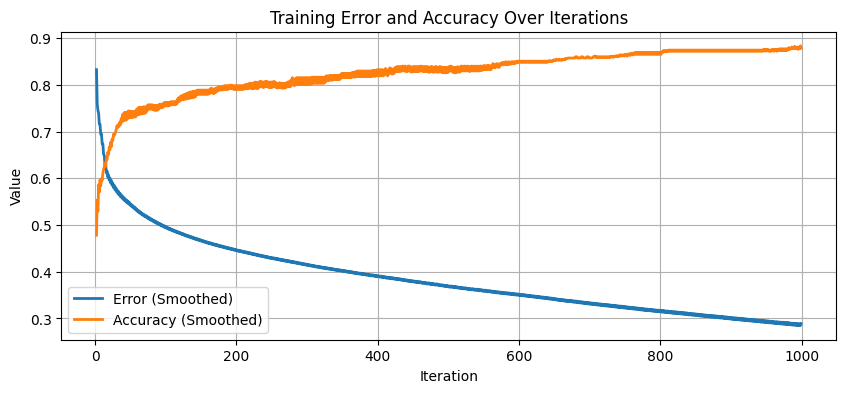

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def moving_average(arr, window_size=3):
    return np.convolve(arr, np.ones(window_size)/window_size, mode='valid')
window_size = 3
error_smoothed = moving_average(err_arr, window_size)
accuracy_smoothed = moving_average(acc_arr, window_size)
plt.figure(figsize=(10,4))
plt.plot(range(window_size - 1, len(err_arr)), error_smoothed, label='Error (Smoothed)', linewidth=2)
plt.plot(range(window_size - 1, len(acc_arr)), accuracy_smoothed, label='Accuracy (Smoothed)', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Training Error and Accuracy Over Iterations')
plt.legend()
plt.grid(True)
plt.show()


In [95]:
print(f"Error array: {err_arr[0:20]}, Accuracy array: {acc_arr[0:20]}")

Error array: [np.float64(0.9827721703072549), np.float64(0.7596281418909316), np.float64(0.755998623714031), np.float64(0.762875415658923), np.float64(0.7184916449053894), np.float64(0.7368622516386335), np.float64(0.6932118933222011), np.float64(0.7169899822693133), np.float64(0.6725661684614049), np.float64(0.6963580061803222), np.float64(0.6533434266285593), np.float64(0.67167957525979), np.float64(0.6295596606764627), np.float64(0.6465598080965521), np.float64(0.6075586719361272), np.float64(0.6288406054287081), np.float64(0.5983389767033399), np.float64(0.6193403626688149), np.float64(0.5908059662276457), np.float64(0.6117758178276482)], Accuracy array: [np.float64(0.38735177865612647), np.float64(0.6047430830039525), np.float64(0.4426877470355731), np.float64(0.6126482213438735), np.float64(0.5335968379446641), np.float64(0.6126482213438735), np.float64(0.5652173913043478), np.float64(0.6126482213438735), np.float64(0.5731225296442688), np.float64(0.6126482213438735), np.float64(

## Putting our AI Doctor to work

Now's the best part!! We'll use the training data, and see what the model predicts in each image

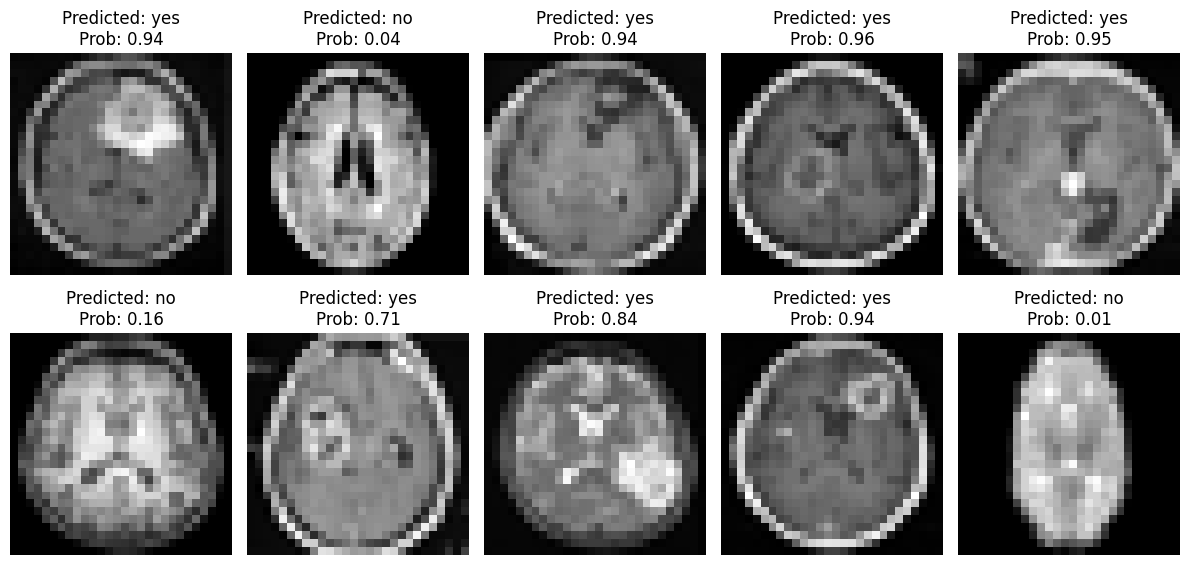

In [102]:
conv_outputs = []
for img in x:
    img = img.reshape(1, 28, 28)
    conv_out = conv_layer.forward(img)
    pooled_out = cnn.max_pooling(conv_out)
    conv_outputs.append(pooled_out)
conv_outputs = np.array(conv_outputs)
x_flat = conv_outputs.reshape(conv_outputs.shape[0], -1).T
predictions, cache = forward_propagation(x_flat, parameters, architecture)
pred_labels = (predictions > 0.5).astype(int).flatten()

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x[i], cmap='gray')
    plt.title(f'Predicted: {class_names[pred_labels[i]]}\nProb: {predictions[0,i]:.2f}')
    plt.axis('off')  # optional: hides axis for cleaner look
plt.tight_layout()
plt.show()

## Conclusion

This notebook took about 6~7 hours to write out and study for, and I can proudly say its a huge accomplishment and learning step!!  
A couple months ago I had just started with ML/DL with Andrew NG after finishing CS50 and since then it's like ive been introduced to a superpower!!  
It's very exciting, and im looking forward for what next in Fast.AI's courses!!  

This was Deep Learning.

==> [Github](https://github.com/lucirie)  
==> [Linkedin](https://www.linkedin.com/in/ziad-alezzi-8727bb345/)